## Import data

In [1]:
import pandas as pd

In [2]:
formai = pd.read_csv('../data/FormAI_dataset_human_readable-V1.csv')
formai.columns = ['filename', 'vulnerability', 'function', 'line', 'error']

formai_category_style = pd.read_csv('../data_extracted/file_category_style.csv')
formai = formai.merge(formai_category_style, on='filename')

# number of unique filenames
print(f"Number of FormAI Files: {len(formai['filename'].unique())}")

Number of FormAI Files: 106138


In [3]:
secure = pd.read_csv('../data/SECURE_ESBMC.csv')
secure_category_style = pd.read_csv('../data_extracted/secure_category_style.csv')
secure = secure.merge(secure_category_style, on='filename')

# number of unique filenames
print(f'Number of Secure FormAI Files: {len(secure.filename.unique())}')

Number of Secure FormAI Files: 15915


In [4]:
def calc_line_numbers(df, directory, file_col='filename'):
    return df[file_col].apply(
        # subract one for the added header comment
        lambda x: len(open(f'{directory}/{x}').read().split('\n')) - 1
    )

In [5]:
formai['num_lines'] = calc_line_numbers(formai, '../data/DATASET')
secure['num_lines'] = calc_line_numbers(secure, '../data/SECURE')

## Calculate vulnerabilities and compare

In [6]:
def vulnerabilities_per_category_agg_at_file(df, result_prefix=''):
    # calculate vulnerabilities per file 
    # (function should be n/a for non-vulnerable, making the count 0!)
    num_vuln = df.groupby('filename').count().function.reset_index(name='num_vuln')

    # calculate number of lines per file, category
    num_lines = df \
                .groupby(['filename', 'category', 'style']) \
                .num_lines.min() \
                .reset_index(name='num_lines')

    # merge the two
    x = num_vuln.merge(num_lines, on='filename')

    # calculate vuln / line, file level
    x['vuln_per_line'] = x.num_vuln / x.num_lines

    # aggregate at the category, style level
    vuln_per_line = x.groupby(['category', 'style']).vuln_per_line.mean()
    vuln_per_file = x.groupby(['category', 'style']).num_vuln.mean()

    # merge the results
    o = pd.concat([vuln_per_line, vuln_per_file], axis=1)
    o.columns = ['vuln_per_line', 'vuln_per_file']
    o.columns = [f'{result_prefix}{c}' for c in o.columns]
    return o

In [7]:
def vulnerabilities_per_category_agg_at_category(df, result_prefix=''):
    # calculate number of vulnerabilities / category
    vulnerable_entries = df[df.vulnerability == 'VULNERABLE']
    num_vuln = vulnerable_entries.groupby(['category', 'style']).count().filename

    # calculate the number of lines / category
    num_lines = df \
                .groupby(['filename', 'category', 'style']).num_lines.min() \
                .reset_index(name='num_lines') \
                .groupby(['category', 'style']).sum().num_lines

    # calculate the number of files / category
    num_files = df.groupby(['category', 'style']).filename.nunique()

    # calculate the per-line and per-file metrics
    vuln_per_line = num_vuln / num_lines
    vuln_per_file = num_vuln / num_files

    # merge the results
    o = pd.concat([num_vuln, num_lines, num_files, vuln_per_line, vuln_per_file], axis=1)
    col_names = ['num_vuln', 'num_lines', 'num_files', 'vuln_per_line', 'vuln_per_file']
    col_names = [f'{result_prefix}{c}' for c in col_names]
    o.columns = col_names

    return o

In [8]:
def vulnerabilities_per_category(df, result_prefix='', agg_at='file'):
    if agg_at not in ('category', 'file'):
        raise ValueError(f'agg_at must be one of (category, file)')
    
    if agg_at == 'category':
        return vulnerabilities_per_category_agg_at_category(df, result_prefix=result_prefix)
    
    if agg_at == 'file':
        return vulnerabilities_per_category_agg_at_file(df, result_prefix=result_prefix)

In [9]:
formai_vuln = vulnerabilities_per_category(formai, result_prefix='formai_')
secure_vuln = vulnerabilities_per_category(secure, result_prefix='secure_')

formai_vuln.reset_index(inplace=True)
secure_vuln.reset_index(inplace=True)

In [10]:
df = secure_vuln.merge(formai_vuln, on=['category', 'style']).fillna(0)

print("Merged files on category and style, calculated vulnerabilities per file")
print(f"Matched a total of {len(df)} categories")

Merged files on category and style, calculated vulnerabilities per file
Matched a total of 15889 categories


## Analyze distributions

### Summary statistics

In [11]:
num_formai_better = sum(df.formai_vuln_per_file > df.secure_vuln_per_file)
num_secure_better = sum(df.formai_vuln_per_file < df.secure_vuln_per_file)

print(f'FormAI better (file level): {num_formai_better}')
print(f'Secure better (file level): {num_secure_better}')

FormAI better (file level): 8524
Secure better (file level): 5688


In [12]:
num_formai_better = sum(df.formai_vuln_per_line > df.secure_vuln_per_line)
num_secure_better = sum(df.formai_vuln_per_line < df.secure_vuln_per_line)

print(f'FormAI better (line level): {num_formai_better}')
print(f'Secure better (line level): {num_secure_better}')

FormAI better (line level): 9257
Secure better (line level): 5321


In [15]:
mu_formai = df.formai_vuln_per_file.mean()
sigma_formai = df.formai_vuln_per_file.std()

mu_secure = df.secure_vuln_per_file.mean()
sigma_secure = df.secure_vuln_per_file.std()

print(f"FormAI (errors / file): µ = {mu_formai:.2f}, σ = {sigma_formai:.2f}")
print(f"SECURE (errors / file): µ = {mu_secure:.2f}, σ = {sigma_secure:.2f}")

FormAI (errors / file): µ = 1.89, σ = 1.95
SECURE (errors / file): µ = 2.80, σ = 7.32


In [16]:
mu_formai = df.formai_vuln_per_line.mean()
sigma_formai = df.formai_vuln_per_line.std()

mu_secure = df.secure_vuln_per_line.mean()
sigma_secure = df.secure_vuln_per_line.std()

print(f"FormAI (errors / line): µ = {mu_formai:.6f}, σ = {sigma_formai:.6f}")
print(f"SECURE (errors / line): µ = {mu_secure:.6f}, σ = {sigma_secure:.6f}")

FormAI (errors / line): µ = 0.027962, σ = 0.029347
SECURE (errors / line): µ = 0.034283, σ = 0.087370


### Plotting

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [19]:
df_for_dist = []
for _, row in df.iterrows():
    df_for_dist.append({
        'category': row['category'],
        'style': row['style'],
        'dataset': 'FormAI',
        'vuln_per_file': row['formai_vuln_per_file'],
        'vuln_per_line': row['formai_vuln_per_line'],
    })
    df_for_dist.append({
        'category': row['category'],
        'style': row['style'],
        'dataset': 'Secure FormAI',
        'vuln_per_file': row['secure_vuln_per_file'],
        'vuln_per_line': row['secure_vuln_per_line'],
    })

df_for_dist = pd.DataFrame(df_for_dist)

/Users/parth/.pyenv/versions/3.11/envs/cset/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


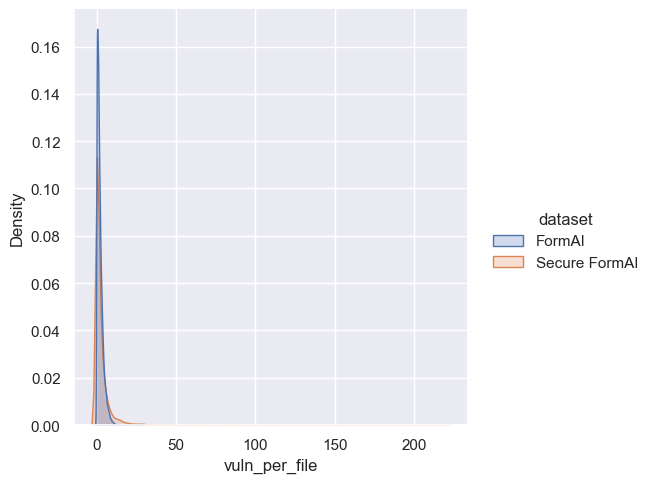

In [20]:
sns.displot(
    df_for_dist,
    x='vuln_per_file',
    hue='dataset',
    kind='kde',
    fill=True
)

/Users/parth/.pyenv/versions/3.11/envs/cset/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


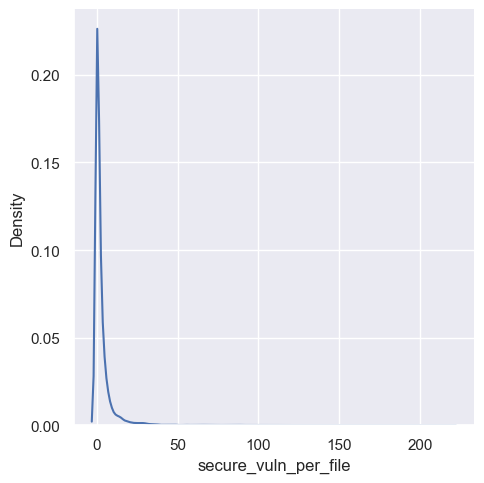

In [21]:
sns.displot(
    df.secure_vuln_per_file,
    kind='kde'
)

/Users/parth/.pyenv/versions/3.11/envs/cset/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


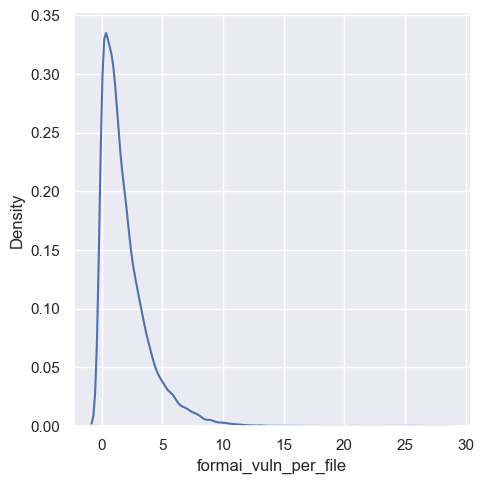

In [22]:
sns.displot(
    df.formai_vuln_per_file,
    kind='kde'
)

In [ ]:
vuln = secure[secure.vulnerability == 'VULNERABLE']
vuln.groupby('filename').count().vulnerability.hist(bins=100)